In [4]:
import datetime
import pathlib

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from lifelines import CoxPHFitter
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
)
from statsmodels.duration.hazard_regression import PHReg, PHRegResults


In [5]:
root_dir = pathlib.Path('../data')
combined_dir = root_dir/'combined'/'2'
df = pd.read_parquet(combined_dir)

In [6]:
df[['FELONY','MISDEMEANOR','VIOLATION']] = df[['FELONY','MISDEMEANOR','VIOLATION']].fillna(0)

In [7]:
df.drop([
    'descriptor', 'resolution_description',
       'resolution_action_updated_date',
       'incident_zip', 'city', 'bbl','status',
       'closed_H','created_date','closed_date','sector',
       'latitude', 'longitude', 'due_date','created','date_H',
       'created', 'created_bo', 'created_ag', 'created_co',
       'created_bo_ag', 'open', 'open_bo', 'open_ag', 'open_co',
       'open_bo_ag','open_bo_co','precip_period_hrs', 'precip_accumulation_mm','direction_deg',
    #    'created_bo_co','temperature_c','speed_mps','dew_temperature_c'
       ], axis='columns', inplace=True)

In [154]:

df.dropna(inplace=True)

# drop very small classes
df = df[~df['borough'].isin({'Unspecified'})]
df['precinct'] = df['precinct'].astype(float).astype('int64[pyarrow]')
# df['direction_deg'] = df['direction_deg'].astype('int64[pyarrow]')

In [ ]:
## Hyper params

drop_strata_threshold = 50
drop_strata = False

sparse_data = False
random_state = 12


strata = ['complaint_type','precinct']
categorical_feats = {
    'month','day_of_week','hour',
    'borough','complaint_type','precinct'
}




In [ ]:
for s in strata:
    categorical_feats.remove(s)
categorical_feats = list(categorical_feats)

In [155]:
df['month'] = df['created_H'].dt.month
df['day_of_week'] = df['created_H'].dt.day_of_week
df['hour'] = df['created_H'].dt.hour
df.drop('created_H', axis='columns', inplace=True)

In [2]:
def strata_threshold_remove(df, strata, drop_strata_threshold=50):
    strata_sizes = df[strata+['hours_to_complete']].groupby(strata).count().sort_values(by='hours_to_complete').rename({'hours_to_complete':'count'}, axis='columns')
    # drop_strata_threshold = 50
    # print()
    dropped_strata_names = strata_sizes[strata_sizes['count'] < drop_strata_threshold].index
    if len(strata) > 1:
        strata_cols = df[strata].apply(tuple, axis=1)
    else:
        strata_cols = df[strata]
    # dropped_strata_names
    drop_idxs = strata_cols.isin(set(dropped_strata_names))
    df = df[~drop_idxs]
    print(f"dropped {drop_idxs.sum()} entries from strata below threshold {drop_strata_threshold}")
    return dropped_strata_names, strata_sizes


if drop_strata is True:
    dropped_strata, strata_sizes = strata_threshold_remove(df, strata, drop_strata_threshold)
    # ax = strata_sizes.loc[list(dropped_strata_names)].plot.barh()
    ax = strata_sizes[strata_sizes.index.isin(dropped_strata)].plot.barh()
    fig = ax.get_figure()
    fig.set_size_inches((15,100))



NameError: name 'drop_strata' is not defined

In [164]:
def process_categorical(df:pd.DataFrame, categorical_feats:list[str], strata:list[str], sparse_data:bool=False, random_state = 12):
    ohe = OneHotEncoder(drop='first', sparse_output=sparse_data).fit(df[categorical_feats])

    if sparse_data is True:
        spdf = pd.DataFrame.sparse.from_spmatrix(ohe.transform(df[categorical_feats]), columns=ohe.get_feature_names_out(), index=df.index)
        strata = ohe.get_feature_names_out(strata)
    elif sparse_data is False:
        spdf = pd.DataFrame(ohe.transform(df[categorical_feats]), columns=ohe.get_feature_names_out(), index=df.index).astype('float32[pyarrow]')
        df[strata] = df[strata].astype('string[pyarrow]')
    else:
        spdf = df[categorical_feats].astype('category')

    non_cat_feats = [col for col in df.columns if col not in categorical_feats]
    spdf[non_cat_feats] = df[non_cat_feats]

    if sparse_data is True:
        spdf = spdf.astype(pd.SparseDtype("float", 0))

    spdf_train, spdf_test = train_test_split(spdf, train_size=0.6, test_size=0.2, stratify=spdf[strata], random_state=random_state)

    return spdf, spdf_train, spdf_test


spdf, spdf_train, spdf_test = process_categorical(df, categorical_feats, strata, sparse_data=sparse_data, random_state=random_state)

In [169]:
exog = [col for col in spdf if col != 'hours_to_complete']

try:
    # '../models/lifeline_cph_176901437666.pkl'
    # '../models/lifeline_cph_137648952299.pkl'
    cph:CoxPHFitter = joblib.load('../models/lifeline_cph_176901437666.pkl')
except FileNotFoundError:
    cph = CoxPHFitter(penalizer=0.1)
    if sparse_data:
        cph.fit(spdf_train, duration_col='hours_to_complete', strata=strata)
    else:
        cph.fit(spdf_train, duration_col='hours_to_complete', strata=strata)
    cph.print_summary()
    cph_name = hash(cph)
    joblib.dump(cph, f"../models/lifeline_cph_{cph_name}.pkl")


<lifelines.CoxPHFitter: fitted with 442282 total observations, 0 right-censored observations>
             duration col = 'hours_to_complete'
                penalizer = 0.1
                 l1 ratio = 0.0
                   strata = ['complaint_type', 'precinct']
      baseline estimation = breslow
   number of observations = 442282
number of events observed = 442282
   partial log-likelihood = -2696254.51
         time fit was run = 2024-03-24 17:54:05 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
month_2.0               0.09       1.09       0.01             0.07             0.10                 1.08                 1.10
month_3.0               0.06       1.06       0.01             0.04             0.07                 1.05                 1.07
month_4.0               0.02       1.03       0.01             0.01             0.04                 1.01                 1.04
month_5.0              -0.03       0.97       0.01            -0.04            -0.02                 0.96                 0.98
month_6.0              -0.06       0.94       0.01            -0.07            -0.05                 0.93                 0.95
month_7.0              -0.05       0.95       0.01            -0.06            -0.04                 0.94                 0.96
month_8.0              -0.07       0.93       0.01            -0.09            -0.06                 0.92                 0.94
month_9.0              -0.07       0.94       0.01            -0.08            -0.05                 0.93                 0.95
month_10.0             -0.08       0.93       0.01            -0.09            -0.06                 0.92                 0.94
month_11.0             -0.05       0.95       0.01            -0.06            -0.04                 0.94                 0.96
month_12.0             -0.09       0.92       0.01            -0.10            -0.08                 0.90                 0.93
day_of_week_1.0        -0.02       0.98       0.01            -0.03            -0.01                 0.97                 0.99
day_of_week_2.0         0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
day_of_week_3.0        -0.01       0.99       0.01            -0.02            -0.00                 0.98                 1.00
day_of_week_4.0        -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
day_of_week_5.0         0.06       1.06       0.00             0.05             0.07                 1.05                 1.07
day_of_week_6.0         0.09       1.09       0.00             0.08             0.09                 1.08                 1.10
borough_BROOKLYN        0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
borough_MANHATTAN       0.01       1.01       0.01            -0.02             0.03                 0.98                 1.03
borough_QUEENS         -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
borough_STATEN ISLAND  -0.00       1.00       0.02            -0.05             0.05                 0.95                 1.05
hour_1.0                0.07       1.08       0.01             0.06             0.09                 1.06                 1.09
hour_2.0                0.14       1.15       0.01             0.12             0.16                 1.13                 1.17
hour_3.0                0.21       1.23       0.01             0.19             0.23                 1.21                 1.26
hour_4.0                0.27       1.31       0.01             0.24             0.29                 1.28                 1.34
hour_5.0                0.32       1.38       0.01             0.30             0.35                 1.

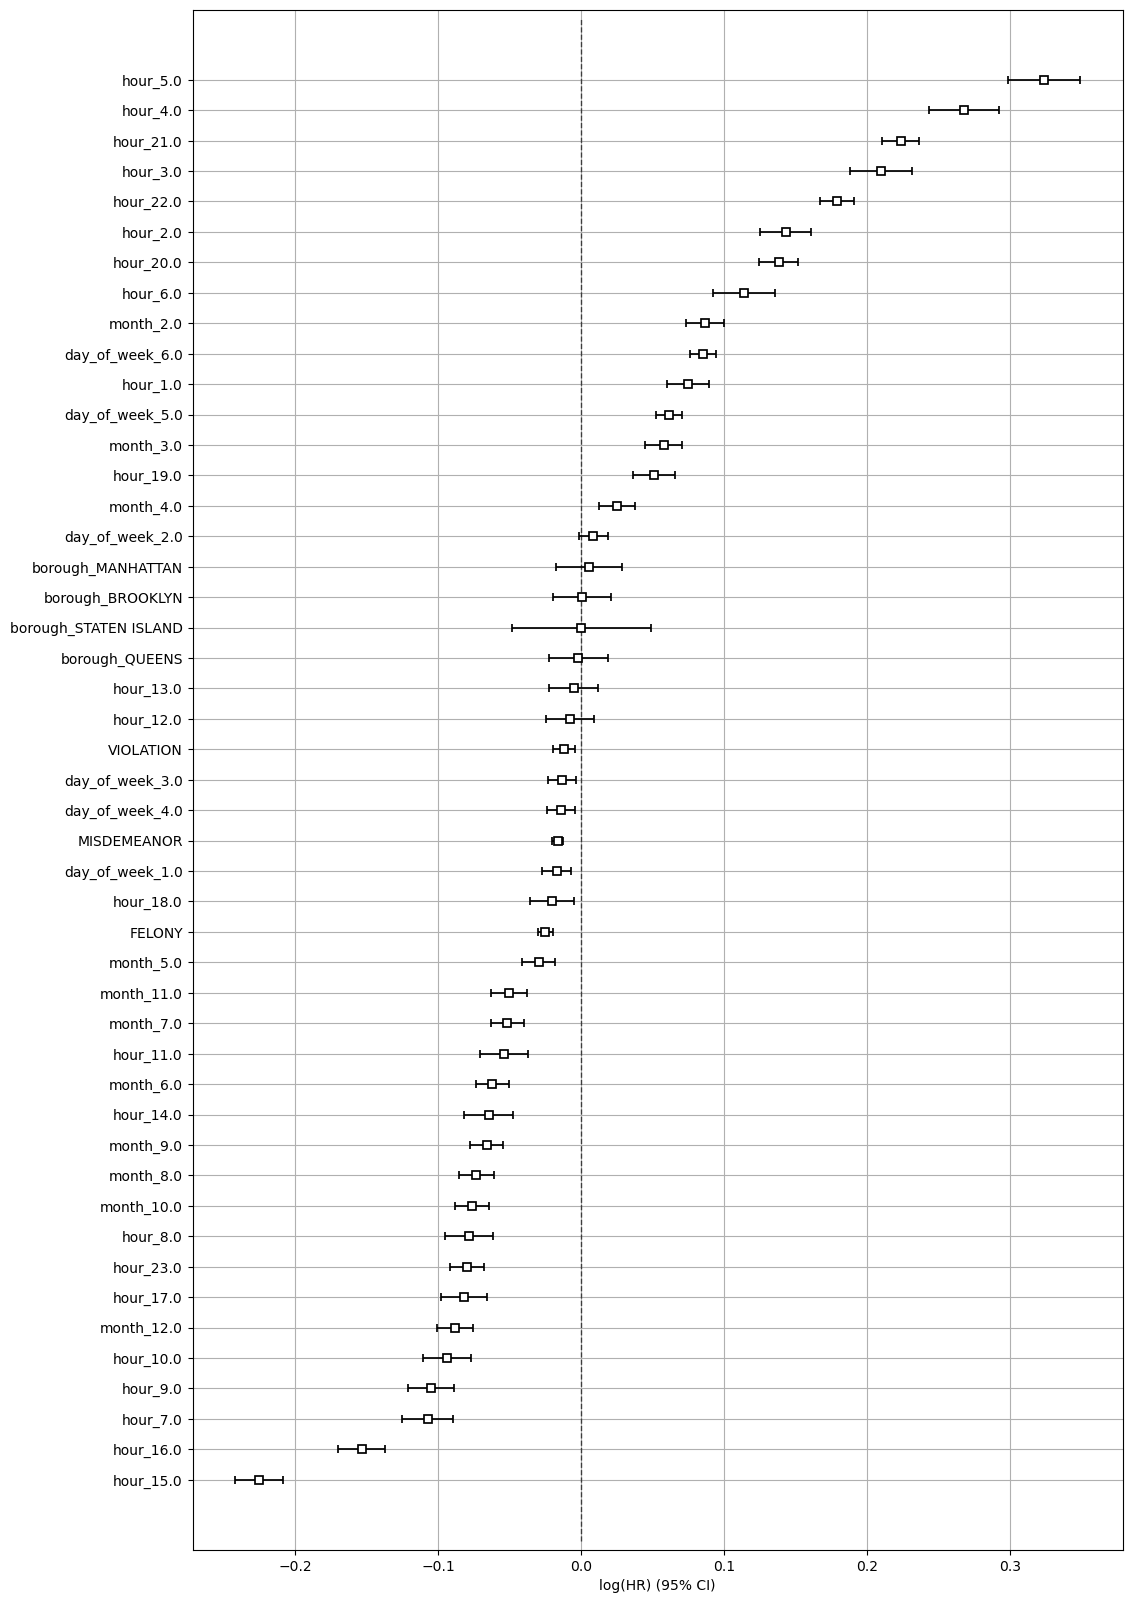

In [170]:
ax = cph.plot()
fig = ax.get_figure()
fig.set_size_inches((12,20))
ax.grid()

In [171]:
tst_sample = spdf_test.sample(frac=0.01, random_state=random_state)

In [172]:


def rmse(df:pd.DataFrame, gt_lbl:str, pre_lbl:str):
    #TODO: seek DoF for better calc
    diff = (df[gt_lbl] - df[pre_lbl])
    return np.sqrt(np.dot(diff.values, diff.values)/ diff.shape[0])
tst_sample['pred_htc'] = cph.predict_expectation(tst_sample)
print(rmse(tst_sample, 'hours_to_complete', 'pred_htc'))


185.9212613410692


c:\Users\Morri\.conda\envs\capstone\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Morri\.conda\envs\capstone\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Predicted vs True Time to Close Complaint in Hours')

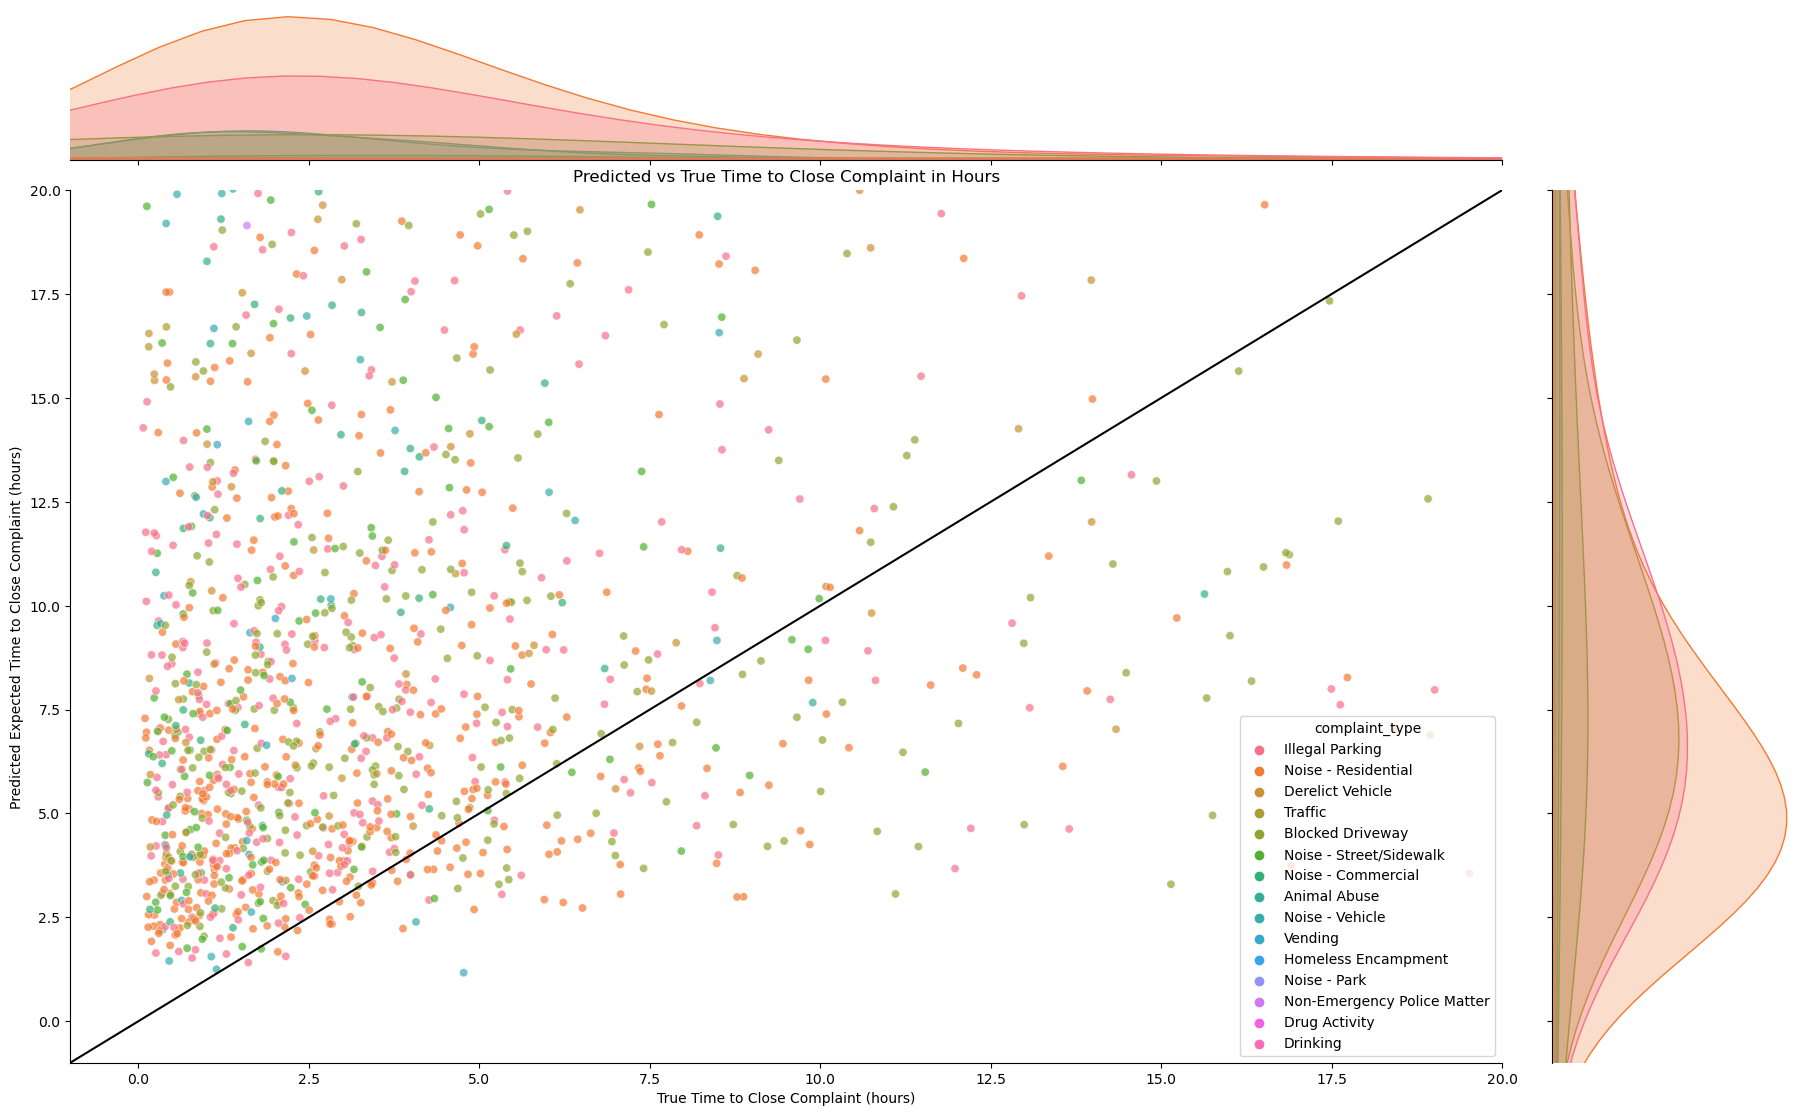

In [178]:


# Define a color palette for different complaint types
palette = sns.color_palette("husl", len(tst_sample['complaint_type'].unique()))

# Create a scatter plot with Seaborn
jg = sns.jointplot(data=tst_sample, x='hours_to_complete', y='pred_htc', hue='complaint_type', palette=palette, alpha=0.7)
ax = jg.ax_joint
# Show the plot
ax.set_ylim(-1, 20)
ax.set_xlim(ax.get_ylim())
plt.plot([-10,100],[-10,100], color='k')
fig = ax.get_figure()
fig.set_size_inches((20,12))
# ax.legend(bbox_to_anchor=[1,0.55])
ax.set_xlabel('True Time to Close Complaint (hours)')
ax.set_ylabel('Predicted Expected Time to Close Complaint (hours)')
ax.set_title('Predicted vs True Time to Close Complaint in Hours')

In [1]:
cph.check_assumptions(spdf_train)

NameError: name 'cph' is not defined

Text(0.5, 1.0, 'Baseline Hazard')

c:\Users\Morri\.conda\envs\capstone\lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\Morri\.conda\envs\capstone\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


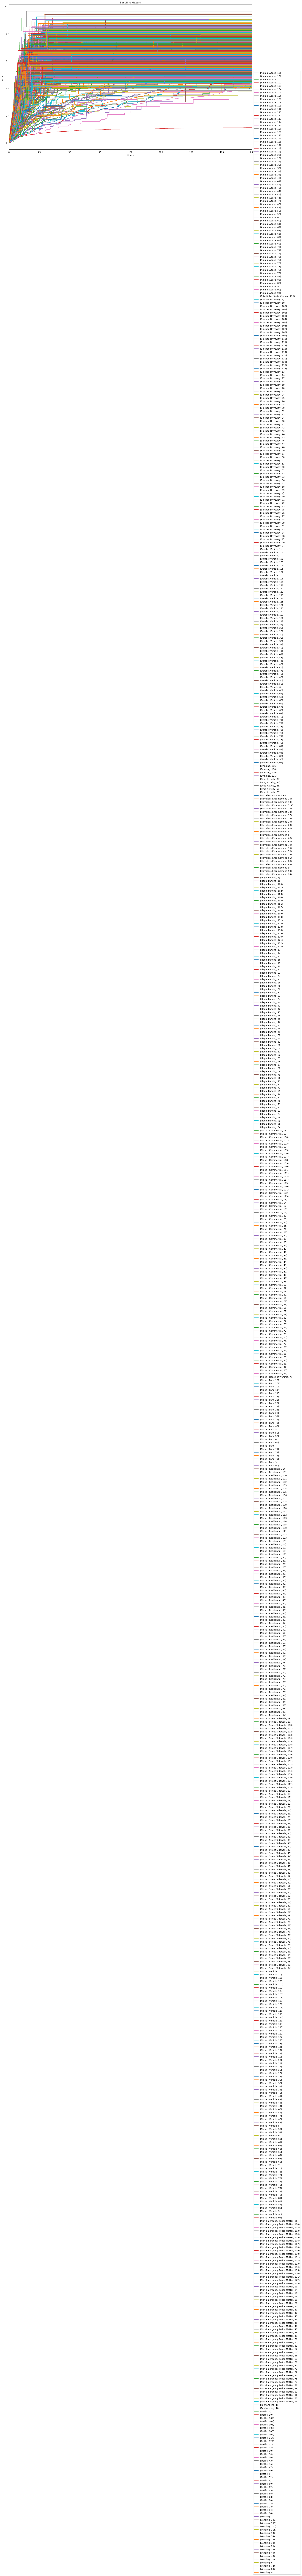

In [175]:
ax = cph.baseline_cumulative_hazard_.plot(drawstyle="steps")
ax.set_xlim((0,200))
fig = ax.get_figure()
fig.set_size_inches((20,12))
ax.legend(bbox_to_anchor=[1,0.55])

ax.set_xlabel('Hours')
ax.set_ylabel('Hazard')
ax.set_title('Baseline Hazard')
# ax.get_legend().remove()
# TODO: find a good cutoff point on the X axis
# any lines that have significan changes in hazard after cutoff get put in a separate plot
# find these by setting a threshold for the slope or rise that if the average after that point is less than
# it gets moved
# for line in ax.lines:
#     new_ax = plt.axes()
#     line.remove()
#     line.set_transform(new_ax.transData)
#     new_ax.add_line(line)
#     new_ax.set_xlim(ax.get_xlim())
#     new_ax.set_ylim(ax.get_ylim())
#     print(line.get_label())
#     data = line.get_xdata()
#     print(len(data), data[-5:])
#     break

In [ ]:
model = PHReg(spdf['hours_to_complete'], spdf[exog])
results:PHRegResults = model.fit()

In [23]:
hash_name = hash(results)
results.save(f'../models/survival_{hash(results)}.sm')
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                          Results: PHReg
==================================================================================================
Model:                             PH Reg                         Sample size:              705269
Dependent variable:                hours_to_complete              Num. events:              705269
Ties:                              Breslow                                                        
--------------------------------------------------------------------------------------------------
                                            log HR log HR SE   HR      t     P>|t|  [0.025  0.975]
--------------------------------------------------------------------------------------------------
month_2.0                                   0.0057    0.0108 1.0057   0.5306 0.5957 0.9847  1.0272
month_3.0                                  -0.0222    0.0133 0.9780  -1.6736 0.0942 0.9529  1.0038
month_4.0                                  -0.0628    0.0139 0.9391  -4.5279 0.0000 0.9139  0.9650
month_5.0                                  -0.0848    0.0143 0.9187  -5.9107 0.0000 0.8932  0.9449
month_6.0                                  -0.0979    0.0134 0.9068  -7.3134 0.0000 0.8833  0.9309
month_7.0                                  -0.0990    0.0119 0.9057  -8.3383 0.0000 0.8849  0.9270
month_8.0                                  -0.1122    0.0103 0.8939 -10.8551 0.0000 0.8760  0.9122
month_9.0                                  -0.0916    0.0093 0.9124  -9.8955 0.0000 0.8960  0.9292
month_10.0                                 -0.1278    0.0080 0.8801 -16.0613 0.0000 0.8664  0.8939
month_11.0                                 -0.1338    0.0076 0.8748 -17.5604 0.0000 0.8618  0.8880
month_12.0                                 -0.1767    0.0085 0.8380 -20.7959 0.0000 0.8242  0.8521
day_of_week_1.0                            -0.0099    0.0048 0.9901  -2.0817 0.0374 0.9809  0.9994
day_of_week_2.0                             0.0158    0.0048 1.0159   3.2619 0.0011 1.0063  1.0256
day_of_week_3.0                            -0.0141    0.0048 0.9860  -2.9576 0.0031 0.9768  0.9952
day_of_week_4.0                            -0.0056    0.0047 0.9944  -1.1852 0.2359 0.9853  1.0037
day_of_week_5.0                             0.0845    0.0048 1.0882  17.6084 0.0000 1.0780  1.0985
day_of_week_6.0                             0.1280    0.0048 1.1365  26.6413 0.0000 1.1259  1.1473
hour_1.0                                    0.0814    0.0073 1.0848  11.0976 0.0000 1.0693  1.1005
hour_2.0                                    0.1370    0.0089 1.1468  15.3870 0.0000 1.1270  1.1670
hour_3.0                                    0.1728    0.0104 1.1886  16.6637 0.0000 1.1647  1.2130
hour_4.0                                    0.2292    0.0114 1.2575  20.0398 0.0000 1.2297  1.2860
hour_5.0                                    0.2448    0.0118 1.2774  20.6719 0.0000 1.2480  1.3073
hour_6.0                                    0.0450    0.0104 1.0460   4.3292 0.0000 1.0249  1.0675
hour_7.0                                   -0.2151    0.0090 0.8064 -23.8880 0.0000 0.7923  0.8208
hour_8.0                                   -0.1392    0.0087 0.8700 -16.0536 0.0000 0.8554  0.8850
hour_9.0                                   -0.1440    0.0089 0.8659 -16.2116 0.0000 0.8510  0.8811
hour_10.0                                  -0.1173    0.0091 0.8893 -12.8779 0.0000 0.8736  0.9053
hour_11.0                                  -0.0779    0.0090 0.9251  -8.6151 0.0000 0.9088  0.9416
hour_12.0                                  -0.0154    0.0094 0.9847  -1.6438 0.1002 0.9667  1.0030
hour_13.0                                  -0.0242    0.0089 0.9761  -2.7264 0.0064 0.9592  0.9932
hour_14.0                                  -0.0897    0.0090 0.9142  -9.9668 0.0000 0.8982  0.9305
hour_15.0                                  -0.2744    0.0088 0.7601 -31.0781 0.0000 0.7470  0.7733
hour_16.0                        

In [32]:
pred = results.predict(exog=spdf[exog].head(6))

In [39]:
vars(pred)

{'predicted_values': array([ 0.21069688, -0.14274659,  0.35491521, -0.39475212,  0.01492839,
         0.25430582]),
 'standard_errors': array([0.07042944, 0.07239506, 0.07255015, 0.07402197, 0.07291485,
        0.07511006])}